In [39]:
# This cell is added by sphinx-gallery
# It can be customized to whatever you like
%matplotlib inline
%pip install pennylane


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [40]:
import pennylane as qml
from pennylane import numpy as np
from pennylane import AdamOptimizer
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import datasets


In [41]:


# load iris dataset
iris = datasets.load_iris()
# Since this is a bunch, create a dataframe
iris_df=pd.DataFrame(iris.data)
iris_df['class']=iris.target

iris_df.columns=['sepal_len', 'sepal_wid', 'petal_len', 'petal_wid', 'class']
iris_df = iris_df[iris_df['class'] != 2]
iris_df.loc[iris_df["class"] == 0, "class"] = 2
iris_df.loc[iris_df["class"] == 1, "class"] = -1
iris_df.loc[iris_df["class"] == 2, "class"] = 1

Y = iris_df['class']
X= iris_df.drop(columns=['class'])
X= X.to_numpy()
Y = Y.to_numpy()
scaler = MinMaxScaler()
normalized_data = scaler.fit_transform(X)
X_norm = normalized_data* np.pi
#normalization = np.sqrt(np.sum(X ** 2, -1))
#X_norm = (X.T / normalization).T * np.pi
#print("First X sample (normalized):", X_norm[0])

# angles for state preparation are new features
# features = np.array([get_angles(x) for x in X_norm], requires_grad=False)
# print("First features sample      :", features[0])
features = X_norm
np.random.seed(0)
num_data = len(Y)
num_train = int(0.75 * num_data)
index = np.random.permutation(range(num_data))
feats_train = features[index[:num_train]]
Y_train = Y[index[:num_train]]
feats_val = features[index[num_train:]]
Y_val = Y[index[num_train:]]

# We need these later for plotting
X_train = X[index[:num_train]]
X_val = X[index[num_train:]]
X_train.shape
Y_train.shape

(75,)

In [42]:
def square_loss(labels, predictions):
    loss = 0
    for l, p in zip(labels, predictions):
        loss = loss + (l - p) ** 2

    loss = loss / len(labels)
    return loss

def accuracy(labels, predictions):

    loss = 0
    for l, p in zip(labels, predictions):
        if abs(l - p) < 1e-5:
            loss = loss + 1
    loss = loss / len(labels)

    return loss

def cost(weights, bias, X, Y):
    predictions = [variational_classifier(weights, bias, x) for x in X]
    return square_loss(Y, predictions)


In [43]:
dev = qml.device("default.qubit", wires=4)

In [44]:
def statepreparation(a):
  qml.AngleEmbedding(features=a, wires=list(range(4)), rotation='Y')


In [45]:
def layer(W):
    qml.Rot(W[0, 0], W[0, 1], W[0, 2], wires=0)
    qml.Rot(W[1, 0], W[1, 1], W[1, 2], wires=1)
    qml.Rot(W[2, 0], W[2, 1], W[2, 2], wires=2)
    qml.Rot(W[3, 0], W[3, 1], W[3, 2], wires=3)

    qml.CNOT(wires=[0, 1])
    qml.CNOT(wires=[1, 2])
    qml.CNOT(wires=[2, 3])
    qml.CNOT(wires=[3, 0])


    

In [46]:
@qml.qnode(dev)
def circuit(weights, angles):
    statepreparation(angles)

    for W in weights:
        layer(W)

    return qml.expval(qml.PauliZ(0))


def variational_classifier(weights, bias, angles):
    return circuit(weights, angles) + bias


def cost(weights, bias, features, labels):
    predictions = [variational_classifier(weights, bias, f) for f in features]
    return square_loss(labels, predictions)


Iter:     1 | Cost: 1.0234974 | Acc train: 0.6000000 | Acc validation: 0.7200000 
Iter:     2 | Cost: 0.9803951 | Acc train: 0.6000000 | Acc validation: 0.7200000 
Iter:     3 | Cost: 0.9455198 | Acc train: 0.6000000 | Acc validation: 0.7200000 
Iter:     4 | Cost: 0.9113259 | Acc train: 0.6533333 | Acc validation: 0.7200000 
Iter:     5 | Cost: 0.8763812 | Acc train: 0.6533333 | Acc validation: 0.7200000 
Iter:     6 | Cost: 0.8410492 | Acc train: 0.6533333 | Acc validation: 0.7200000 
Iter:     7 | Cost: 0.8050143 | Acc train: 0.6533333 | Acc validation: 0.7200000 
Iter:     8 | Cost: 0.7698543 | Acc train: 0.6800000 | Acc validation: 0.7600000 
Iter:     9 | Cost: 0.7318581 | Acc train: 0.7466667 | Acc validation: 0.8000000 
Iter:    10 | Cost: 0.6956878 | Acc train: 0.7600000 | Acc validation: 0.8000000 
Iter:    11 | Cost: 0.6583774 | Acc train: 0.7733333 | Acc validation: 0.8000000 
Iter:    12 | Cost: 0.6200896 | Acc train: 0.8266667 | Acc validation: 0.8400000 
Iter:    13 | Co

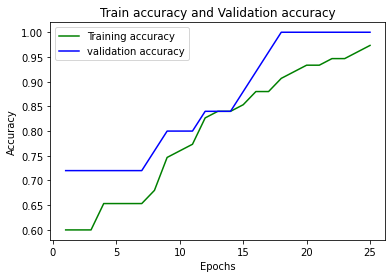

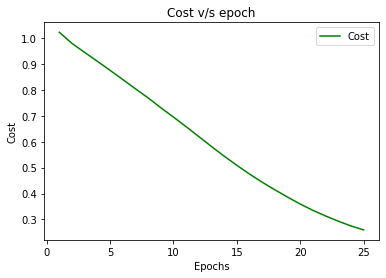

In [47]:
#@qml.qnode(dev, diff_method="backprop")


num_qubits = 4
num_layers = 6

weights_init = 0.01 * np.random.randn(num_layers, num_qubits, 3, requires_grad=True)
bias_init = np.array(0.0, requires_grad=True)

opt = qml.AdamOptimizer()
batch_size = 5

# train the variational classifier
weights = weights_init
bias = bias_init
graph = pd.DataFrame( columns = ["iter", "cost","acc_train", "acc_val"] )
for it in range(25):

    # Update the weights by one optimizer step
    batch_index = np.random.randint(0, num_train, (batch_size,))
    feats_train_batch = feats_train[batch_index]
    Y_train_batch = Y_train[batch_index]
    weights, bias, _, _ = opt.step(cost, weights, bias, feats_train_batch, Y_train_batch)

    # Compute predictions on train and validation set
    predictions_train = [np.sign(variational_classifier(weights, bias, f)) for f in feats_train]
    predictions_val = [np.sign(variational_classifier(weights, bias, f)) for f in feats_val]

    # Compute accuracy on train and validation set
    acc_train = accuracy(Y_train, predictions_train)
    acc_val = accuracy(Y_val, predictions_val)
    graph = graph.append({'iter' : it + 1, 'cost' : cost(weights, bias, features, Y),'acc_train':acc_train,'acc_val':acc_val}, ignore_index=True)
    print(
        "Iter: {:5d} | Cost: {:0.7f} | Acc train: {:0.7f} | Acc validation: {:0.7f} "
        "".format(it + 1, cost(weights, bias, features, Y), acc_train, acc_val)
    )

# graph cost vs 

acc_train = graph['acc_train']
acc_val = graph['acc_val']
epochs = graph['iter']
plt.plot(epochs, acc_train, 'g', label='Training accuracy')
plt.plot(epochs, acc_val, 'b', label='validation accuracy')
plt.title('Train accuracy and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# graph cost vs 

cost = graph['cost']

epochs = graph['iter']
plt.plot(epochs, cost, 'g', label='Cost')
plt.title('Cost v/s epoch')
plt.xlabel('Epochs')
plt.ylabel('Cost')
plt.legend()
plt.show()